Overview: Classify aircraft damage using a pre-trained VGG16 model and generate captions using a Transformer-based pretrained model.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import zipfile
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import random

In [4]:
# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [5]:
#Set the batch size,epochs
batch_size = 32
n_epochs = 5
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

## Part 1 - Classification Problem: Classifying the defect on the aircraft as 'dent' or 'crack'

In [6]:
import tarfile
import urllib.request
import os
import shutil

# URL of the tar file
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar"

# Define the path to save the file
tar_filename = "aircraft_damage_dataset_v1.tar"
extracted_folder = "aircraft_damage_dataset_v1"  # Folder where contents will be extracted

# Download the tar file
urllib.request.urlretrieve(url, tar_filename)
print(f"Downloaded {tar_filename}. Extraction will begin now.")

# Check if the folder already exists
if os.path.exists(extracted_folder):
    print(f"The folder '{extracted_folder}' already exists. Removing the existing folder.")
    
    # Remove the existing folder to avoid overwriting or duplication
    shutil.rmtree(extracted_folder)
    print(f"Removed the existing folder: {extracted_folder}")

# Extract the contents of the tar file
with tarfile.open(tar_filename, "r") as tar_ref:
    tar_ref.extractall()  # This will extract to the current directory
    print(f"Extracted {tar_filename} successfully.")

Downloaded aircraft_damage_dataset_v1.tar. Extraction will begin now.
The folder 'aircraft_damage_dataset_v1' already exists. Removing the existing folder.
Removed the existing folder: aircraft_damage_dataset_v1
Extracted aircraft_damage_dataset_v1.tar successfully.


In [7]:
# Define directories for train, test, and validation splits
extract_path = "aircraft_damage_dataset_v1"
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
valid_dir = os.path.join(extract_path, 'valid')

In [8]:
# Create ImageDataGenerators to preprocess the data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),   # Resize images to the size VGG16 expects
    batch_size=batch_size,
    seed = seed_value,
    class_mode='binary',
    shuffle=True # Binary classification: dent vs crack
)

Found 300 images belonging to 2 classes.


In [10]:
valid_generator =  valid_datagen.flow_from_directory(
    directory=valid_dir,
    class_mode='binary',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 96 images belonging to 2 classes.


In [11]:
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    class_mode='binary',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows,img_cols)
)

Found 50 images belonging to 2 classes.


In [12]:
base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

We extract the output from the last layer of the pre-trained VGG16 model, and then create a new model with this modified output. Then we will freeze the base VGG16 model layers so that their weights will not be updated during training.

In [13]:
output = base_model.layers[-1].output
output = keras.layers.Flatten()(output)
base_model = Model(base_model.input, output)

for layer in base_model.layers:
    layer.trainable = False

In [14]:
# Build the custom model
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model training

In [16]:
history = model.fit(
    train_generator, 
    epochs=n_epochs, 
    validation_data=valid_generator, 
   
)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.5192 - loss: 0.7190 - val_accuracy: 0.6042 - val_loss: 0.6338
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.7010 - loss: 0.5582 - val_accuracy: 0.6979 - val_loss: 0.5821
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.7865 - loss: 0.4846 - val_accuracy: 0.7188 - val_loss: 0.5486
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.8258 - loss: 0.3879 - val_accuracy: 0.6562 - val_loss: 0.6457
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.8663 - loss: 0.3421 - val_accuracy: 0.7083 - val_loss: 0.5098


In [17]:
train_history = model.history.history  # After training

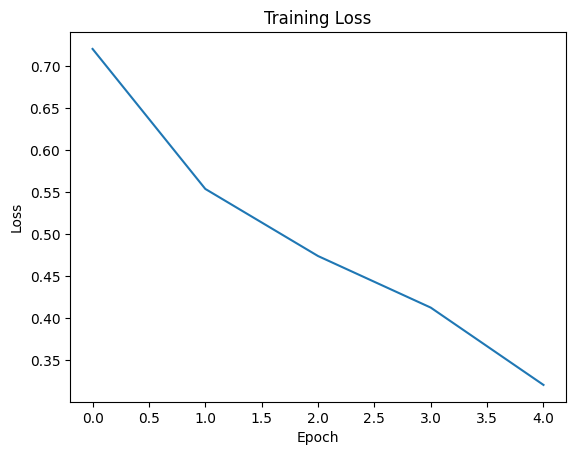

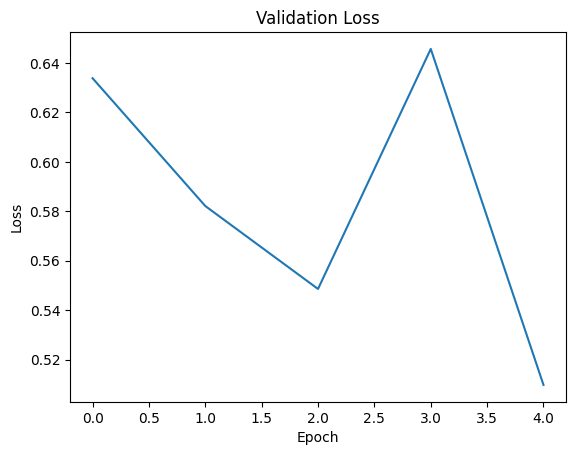

In [18]:
# Plot the loss for both training and validation
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['loss'])
plt.show()

plt.title("Validation Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['val_loss'])
plt.show()

Text(0, 0.5, 'Accuracy')

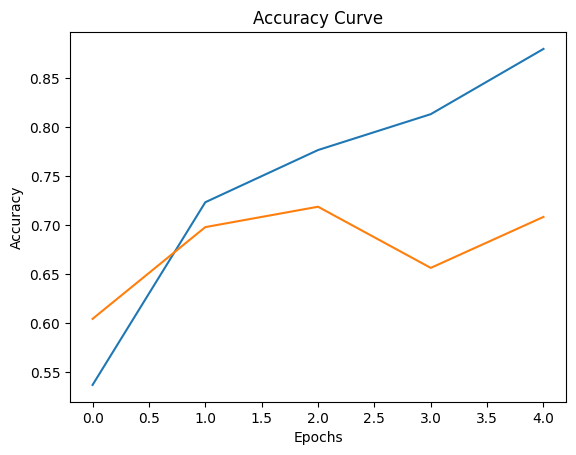

In [19]:
figsize=(5, 5)
plt.plot(train_history['accuracy'], label='Training Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Evaluation

In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6875 - loss: 0.7326
Test Loss: 0.7326
Test Accuracy: 0.6875


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to plot a single image and its prediction
def plot_image_with_title(image, model, true_label, predicted_label, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # Convert labels from one-hot to class indices if needed, but for binary labels it's just 0 or 1
    true_label_name = class_names[true_label]  # Labels are already in class indices
    pred_label_name = class_names[predicted_label]  # Predictions are 0 or 1

    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
    plt.axis('off')
    plt.show()

# Function to test the model with images from the test set
def test_model_on_image(test_generator, model, index_to_plot=0):
    # Get a batch of images and labels from the test generator
    test_images, test_labels = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(test_images)

    # In binary classification, predictions are probabilities (float). Convert to binary (0 or 1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Get the class indices from the test generator and invert them to get class names
    class_indices = test_generator.class_indices
    class_names = {v: k for k, v in class_indices.items()}  # Invert the dictionary

    # Specify the image to display based on the index
    image_to_plot = test_images[index_to_plot]
    true_label = test_labels[index_to_plot]
    predicted_label = predicted_classes[index_to_plot]

    # Plot the selected image with its true and predicted labels
    plot_image_with_title(image=image_to_plot, model=model, true_label=true_label, predicted_label=predicted_label, class_names=class_names)




1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


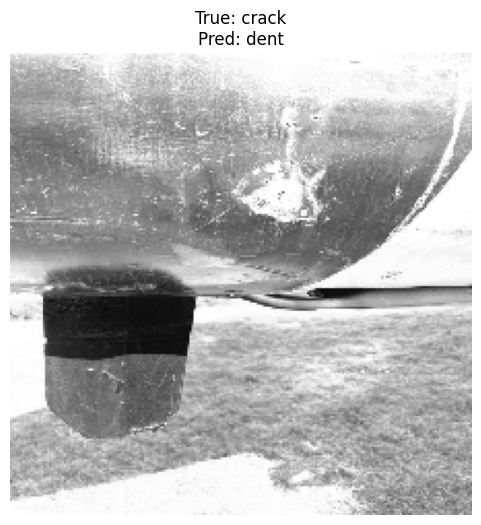

In [22]:
test_model_on_image(test_generator, model, 3)

Save the model

In [33]:
model.save('aircraft_model.h5')


In [1]:
from tensorflow.keras.models import load_model

# reload the model
model = load_model('aircraft_model.h5')

## Part 2: Image Captioning and Summarization using BLIP Pretrained Model

In [ ]:
# %pip install torch

  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 1.6/204.1 MB 8.4 MB/s eta 0:00:25
    --------------------------------------- 3.7/204.1 MB 9.5 MB/s eta 0:00:22
   - -------------------------------------- 5.8/204.1 MB 9.5 MB/s eta 0:00:21
   - -------------------------------------- 7.9/204.1 MB 9.5 MB/s eta 0:00:21
   - -------------------------------------- 9.7/204.1 MB 9.7 MB/s eta 0:00:20
   -- ------------------------------------- 11.3/204.1 MB 9.0 MB/s eta 0:00:22
   -- ------------------------------------- 12.8/204.1 MB 8.9 MB/s eta 0:00:22
   -- ------------------------------------- 14.9/204.1 MB 8.9 MB/s eta 0:00:22
   --- ------------------------------------ 16.8/204.1 MB 9.0 MB/s eta 0:00:21
   --- ------------------------------------ 18.6/204.1 MB 9.0 MB/s eta 0:00:21
   ---- ----------------------------------- 20.7/204.1 MB 9.0 MB/s eta 0:00:21
  

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [29]:
%pip install --upgrade transformers==4.38.2

  Using cached transformers-4.38.2-py3-none-any.whl.metadata (130 kB)
Using cached transformers-4.38.2-py3-none-any.whl (8.5 MB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------------------------------- ------ 1.8/2.2 MB 9.2 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 6.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.0
    Uninstalling transformers-4.51.0:
      Successfully uninstalled transformers-4.51.0
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [31]:
pip show transformers


Name: transformers
Version: 4.38.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: c:\Users\wldhg\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [32]:
pip show torch

Name: torch
Version: 2.6.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: c:\Users\wldhg\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, setuptools, sympy, typing-extensions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Load the required libraries
import torch
import tensorflow as tf
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

c:\Users\wldhg\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


In [3]:
#load the pretrained BLIP processor and model:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

c:\Users\wldhg\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
    def __init__(self, processor, model, **kwargs):
        """
        Initialize the custom Keras layer with the BLIP processor and model.

        Args:
            processor: The BLIP processor for preparing inputs for the model.
            model: The BLIP model for generating captions or summaries.
        """
        super().__init__(**kwargs)
        self.processor = processor
        self.model = model

    def call(self, image_path, task):
        # Use tf.py_function to run the custom image processing and text generation
        return tf.py_function(self.process_image, [image_path, task], tf.string)

    def process_image(self, image_path, task):
        """
        Perform image loading, preprocessing, and text generation.

        Args:
            image_path: Path to the image file as a string.
            task: The type of task ("caption" or "summary").

        Returns:
            The generated caption or summary as a string.
        """
        try:
            # Decode the image path from the TensorFlow tensor to a Python string
            image_path_str = image_path.numpy().decode("utf-8")

            # Open the image using PIL and convert it to RGB format
            image = Image.open(image_path_str).convert("RGB")

            # Set the appropriate prompt based on the task
            if task.numpy().decode("utf-8") == "caption":
                prompt = "This is a picture of"  # Modify prompt for more natural output
            else:
                prompt = "This is a detailed photo showing"  # Modify for summary

            # Prepare inputs for the BLIP model
            inputs = self.processor(images=image, text=prompt, return_tensors="pt")

            # Generate text output using the BLIP model
            output = self.model.generate(**inputs)

            # Decode the output into a readable string
            result = self.processor.decode(output[0], skip_special_tokens=True)
            return result
        except Exception as e:
            # Handle errors during image processing or text generation
            print(f"Error: {e}")
            return "Error processing image"

In [ ]:
# Define a helper function to use the custom Keras layer
def generate_text(image_path, task):
  # Create an instance of the custom Keras layer
    blip_layer = BlipCaptionSummaryLayer(processor, model)
    # Call the layer with the provided inputs
    return blip_layer(image_path, task)

In [7]:
# Path to an example image 
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/144_10_JPG_jpg.rf.4d008cc33e217c1606b76585469d626b.jpg")  # actual path of image

# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Decode and print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

# Generate a summary for the image
summary = generate_text(image_path, tf.constant("summary"))
# Decode and print the generated summary
print("Summary:", summary.numpy().decode("utf-8"))

c:\Users\wldhg\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Caption: this is a picture of a plane
Summary: this is a detailed photo showing the engine of a boeing 747


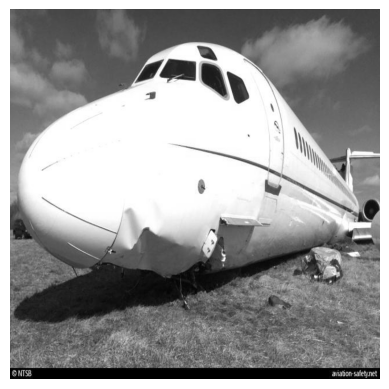

In [9]:
import matplotlib.pyplot as plt
# We will use the following image to display Caption and Summary for Task 9 and 10
# URL of the image
image_url = "aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg"
# Load and display the image
img = plt.imread(image_url)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [10]:
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg") 

In [12]:
generate_text(image_path, tf.constant("summary"))

c:\Users\wldhg\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


<tf.Tensor: shape=(), dtype=string, numpy=b'this is a detailed photo showing the damage to the fuselage of the aircraft'>